# Tesla Stock Prediction Model

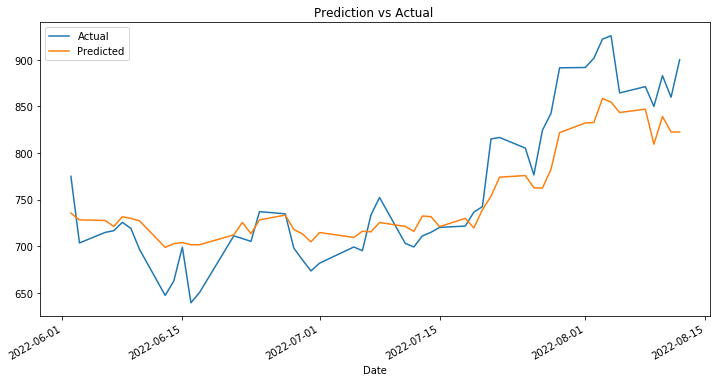

- The above is the chart that depicts the ML model's prediction with an RMSE of 35.
- It was successful in capturing the trend of the stock therefore it was used to forecast the stock price for the next 30 days. 

# Data Collection & Pre-Processing

In [1]:
#!pip install yfinance
#!pip install snscrape
#!pip install praw
#!pip install dotenv

In [306]:
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import time
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize, pos_tag,pos_tag_sents
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD as svd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor as RFR
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import catboost as cb
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score
import pickle
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
import warnings
warnings.filterwarnings("ignore")

### Yahoo Finance 

In [307]:
START = '2020-06-27'
TODAY = date.today().strftime("%Y-%m-%d")

stocks = ('TSLA')


#Writing a function to download data
def load_data(ticker):
    price = yf.download(ticker,START,TODAY)
    price.reset_index(inplace = True)
    return price

price = load_data(stocks)
price.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
532,2022-08-08,885.000000,915.599976,867.260010,871.270020,871.270020,32998000
533,2022-08-09,870.880005,877.190002,838.059998,850.000000,850.000000,28748200
534,2022-08-10,891.200012,892.530029,850.109985,883.070007,883.070007,31639600
535,2022-08-11,889.539978,894.710022,857.500000,859.890015,859.890015,23385000
536,2022-08-12,868.250000,900.479980,855.099976,900.090027,900.090027,26443300


### Twitter 

In [308]:
import snscrape.modules.twitter as sntwitter
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [309]:
#Reading past 2 years of tweets from Git

data = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/Foundational_Project/pre-mid-eval/TSLATWEETS.csv',
usecols = ['Date','Tweet'])
data['Date']= data['Date'].str.split(" ").str[0].astype('datetime64[ns]') #Normalizing datetime column
data['Date'] = data['Date'].dt.date 


query = "tesla Tesla TSLA TESLA min_faves:100 lang:en since:2022-08-09"
tweets = []

for tweet in sntwitter.TwitterSearchScraper(query).get_items():  #Scraping additional tweets from 2022-08-09
    tweets.append([tweet.date,tweet.content])

df = pd.DataFrame(tweets,columns = ['Date','Tweet'])             #Normalizing datetime column
df['Date'] = df['Date'].dt.date

tesla = pd.concat([df, data[:]]).reset_index(drop = True)        # Concatenating Git csv and live scraped tweets
tesla['Date'] = tesla['Date'].astype('datetime64[ns]')
tesla

,Date,Tweet
0,2022-08-13,https://t.co/fRmtiGXGwe - Tesla’s DEMAND Is So...
1,2022-08-13,It’s insane that people think demand is an iss...
2,2022-08-13,Tesla Full Self-Driving is the only self-drivi...
3,2022-08-13,72 Minutes of zero takeover driving in traffic...
4,2022-08-13,If every car had pedestrian detection as power...
...,...,...
9867,2020-06-27,According to the online survey of Sina Technol...
9868,2020-06-26,Elon Musk Explains Why Tesla $TSLA Should Be C...
9869,2020-06-26,Tesla $TSLA Q2 2020 Results May Be Better Than...
9870,2020-06-26,@FT If Zoox is worth $1.2n and is more advance...


In [310]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9872 entries, 0 to 9871
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9872 non-null   datetime64[ns]
 1   Tweet   9872 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 154.4+ KB


# Reddit

In [365]:
import praw
from datetime import datetime
from dotenv import load_dotenv
import os

In [7]:
load_dotenv()

True

In [8]:
#reddit api config

client_id = os.getenv('client_id')
secret = os.getenv('secret')
name = os.getenv('name')

In [69]:
reddit = praw.Reddit(client_id = client_id,client_secret = secret,user_agent = name)
tesla_posts = reddit.subreddit('TSLA').hot(limit=10)
tesla_posts

#### Run only when to scrape last 1000 threads on TSLA subreddit, else skip to the next cell

In [70]:
# Run only when to scrape last 1000 threads on TSLA subreddit, else skip to the next cell

posts = []
tesla_posts = reddit.subreddit('TSLA')

for post in tesla_posts.hot(limit=1000):
    posts.append([post.title, post.score,post.subreddit,post.selftext,datetime.utcfromtimestamp(post.created)])
posts = pd.DataFrame(posts,columns=['title','score','subreddit','body', 'created'])

In [311]:
#Reading the last 1000 (updated on 10/08/2022) hosted on Git

reddit_df = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/Foundational_Project/pre-mid-eval/reddit.csv',usecols = ['created','title','body'])
reddit_df['created']= reddit_df['created'].str.split(" ").str[0].astype('datetime64[ns]') #Normalizing datetime column
reddit_df['created'] = reddit_df['created'].dt.date
reddit_df['created'] = reddit_df['created'].astype('datetime64[ns]')
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    949 non-null    object        
 1   body     610 non-null    object        
 2   created  949 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 22.4+ KB


- To be updated every month manually and hosted on GitHub as Reddit API only allows the past 1000 content pieces of a subreddit.

In [312]:
#Combining title and body columns

reddit_df['full_text'] = reddit_df['title'].fillna('') + ' '+ reddit_df['body'].fillna('')
reddit_df.head()

,title,body,created,full_text
0,Tesla going further down this week :(,Elon just sold 7 billion in TSLA shares so I’d...,2022-08-10,Tesla going further down this week :( Elon jus...
1,Tesla’s next gigafactory might be in Canada,NaN,2022-08-10,Tesla’s next gigafactory might be in Canada
2,"Tesla Is Miles Ahead of the Competition, Says ...","Tesla Is Miles Ahead of the Competition, Says...",2022-08-08,"Tesla Is Miles Ahead of the Competition, Says ..."
3,Mr (not) Wonderful,#TSLA #Tesla $TSLA @kevinolearytv stop talking...,2022-08-08,Mr (not) Wonderful #TSLA #Tesla $TSLA @kevinol...
4,TSLA,Is tsla going up after the stock split?,2022-08-08,TSLA Is tsla going up after the stock split?


## Financial Ratios/Metrics

In [313]:
#Reading Fiancial Metrics
ratios = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/Foundational_Project/pre-mid-eval/tsla_ratios.csv')
ratios['Date'] = ratios['Date'].astype('datetime64[ns]')


ratios['quarter'] = ratios['Date'].dt.quarter
ratios['year'] = ratios['Date'].dt.year
ratios['quarter_year'] = ratios.quarter.astype(str) + ' ' + ratios.year.astype(str)
ratios.drop(['quarter','year'],axis = 1,inplace=True)
ratios.head()

,Date,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,Pre-Tax Proﬁt Margin,Net Proﬁt Margin,Asset Turnover,...,Book Value Per Share,Operating Cash Flow Per Share,Free Cash Flow Per Share,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,Buyback Yield / Dilution,Total Shareholder Return,quarter_year
0,2022-09-30,1.4308,0.0722,0.1190,25.0030,14.5506,14.5506,14.6097,13.3400,0.2472,...,35.7704,2.0415,1.3514,"6,83,185",73.32,10.39,19.18,-6.80%,-6.80%,3 2022
1,2022-06-30,1.4308,0.0722,0.1190,25.0030,14.5506,14.5506,14.6097,13.3400,0.2472,...,35.7704,2.0415,1.3514,"6,83,185",73.32,10.39,19.18,-6.80%,-6.80%,2 2022
2,2022-03-31,1.3540,0.0828,0.1377,29.1107,19.2099,19.2099,19.3325,17.6903,0.2840,...,33.7326,3.4529,1.9257,"11,00,507",132.60,17.91,32.67,-7.60%,-7.60%,1 2022
3,2021-12-31,1.3753,0.1446,0.2203,27.3548,14.7469,14.7469,14.8710,13.0989,0.2852,...,30.0242,4.0285,2.4531,"10,50,414",192.30,19.72,35.16,-6.52%,-6.52%,4 2021
4,2021-09-30,1.3851,0.1875,0.2924,26.6046,14.5671,14.5671,13.6803,11.7613,0.2379,...,27.7779,2.7903,1.1836,"7,59,796",221.38,16.39,28.38,-6.51%,-6.51%,3 2021


# Combining

In [314]:
#Combining date and tweets
final = price.merge(tesla,on = 'Date',how = 'left')
final_reddit = final.merge(reddit_df,left_on='Date',right_on='created',how = 'left')
final_reddit.drop(['created','title','body'],axis = 1,inplace=True)
final = final_reddit
final['text'] = final['Tweet'].fillna('') +' '+ final['full_text'].fillna('')
final.drop(['Tweet','full_text'],axis = 1,inplace = True)
final

,Date,Open,High,Low,Close,Adj Close,Volume,text
0,2020-06-26,198.955994,199.00000,190.973999,191.947998,191.947998,44274500,Elon Musk Explains Why Tesla $TSLA Should Be C...
1,2020-06-26,198.955994,199.00000,190.973999,191.947998,191.947998,44274500,Tesla $TSLA Q2 2020 Results May Be Better Than...
2,2020-06-26,198.955994,199.00000,190.973999,191.947998,191.947998,44274500,@FT If Zoox is worth $1.2n and is more advance...
3,2020-06-26,198.955994,199.00000,190.973999,191.947998,191.947998,44274500,"""Electrek has now learned that Tesla might sur..."
4,2020-06-29,193.802002,202.00000,189.703995,201.869995,201.869995,45132000,Tesla Model 3 on fire &amp; still moving. No o...
...,...,...,...,...,...,...,...,...
17332,2022-08-12,868.250000,900.47998,855.099976,900.090027,900.090027,26443300,Teslas seem more expensive than they really ar...
17333,2022-08-12,868.250000,900.47998,855.099976,900.090027,900.090027,26443300,Sandy Munro talks EVs on @Autoline After Hours...
17334,2022-08-12,868.250000,900.47998,855.099976,900.090027,900.090027,26443300,One million miles are driven on Tesla Full Sel...
17335,2022-08-12,868.250000,900.47998,855.099976,900.090027,900.090027,26443300,Tesla is turning a corner on FSD. Chuck’s corn...


In [315]:
#Extracting quarter and year from date
final['quarter'] = final['Date'].dt.quarter
final['year'] = final['Date'].dt.year
final['quarter_year'] = final.quarter.astype(str) + ' ' + final.year.astype(str)
final.drop(['quarter','year'],axis=1,inplace=True)
final.head()

,Date,Open,High,Low,Close,Adj Close,Volume,text,quarter_year
0,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,Elon Musk Explains Why Tesla $TSLA Should Be C...,2 2020
1,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,Tesla $TSLA Q2 2020 Results May Be Better Than...,2 2020
2,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,@FT If Zoox is worth $1.2n and is more advance...,2 2020
3,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,"""Electrek has now learned that Tesla might sur...",2 2020
4,2020-06-29,193.802002,202.0,189.703995,201.869995,201.869995,45132000,Tesla Model 3 on fire &amp; still moving. No o...,2 2020


In [316]:
#Merging the financial ratios
final_tesla = final.merge(ratios,on='quarter_year',how = 'left')
final_tesla.drop(['Date_y','quarter_year'],axis=1,inplace=True)
final_tesla.rename(columns={'Date_x':'Date'},inplace=True)
final_tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume,text,Current Ratio,Long-term Debt / Capital,...,ROI - Return On Investment,Book Value Per Share,Operating Cash Flow Per Share,Free Cash Flow Per Share,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,Buyback Yield / Dilution,Total Shareholder Return
0,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,Elon Musk Explains Why Tesla $TSLA Should Be C...,1.2499,0.4938,...,0.609,11.5312,0.9485,0.44,205690,543.93,7.79,20.31,-4.86%,-4.86%
1,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,Tesla $TSLA Q2 2020 Results May Be Better Than...,1.2499,0.4938,...,0.609,11.5312,0.9485,0.44,205690,543.93,7.79,20.31,-4.86%,-4.86%
2,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,@FT If Zoox is worth $1.2n and is more advance...,1.2499,0.4938,...,0.609,11.5312,0.9485,0.44,205690,543.93,7.79,20.31,-4.86%,-4.86%
3,2020-06-26,198.955994,199.0,190.973999,191.947998,191.947998,44274500,"""Electrek has now learned that Tesla might sur...",1.2499,0.4938,...,0.609,11.5312,0.9485,0.44,205690,543.93,7.79,20.31,-4.86%,-4.86%
4,2020-06-29,193.802002,202.0,189.703995,201.869995,201.869995,45132000,Tesla Model 3 on fire &amp; still moving. No o...,1.2499,0.4938,...,0.609,11.5312,0.9485,0.44,205690,543.93,7.79,20.31,-4.86%,-4.86%


In [317]:
#Group all text data together
final_tesla['text'] = final_tesla.groupby(['Date'])['text'].transform(
                                              lambda x: ' '.join(x))
tesla = final_tesla.drop_duplicates() 
tesla= tesla.groupby('Date').first()
tesla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537 entries, 2020-06-26 to 2022-08-12
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Open                            537 non-null    float64
 1   High                            537 non-null    float64
 2   Low                             537 non-null    float64
 3   Close                           537 non-null    float64
 4   Adj Close                       537 non-null    float64
 5   Volume                          537 non-null    int64  
 6   text                            537 non-null    object 
 7   Current Ratio                   537 non-null    float64
 8   Long-term Debt / Capital        537 non-null    float64
 9   Debt/Equity Ratio               537 non-null    float64
 10  Gross Margin                    537 non-null    float64
 11  Operating Margin                537 non-null    float64
 12  EBIT Margin      

# Text Pre-Processing

In [318]:
#Cleaning text data
def preprocessing(text):
    stop = nltk.corpus.stopwords.words('english')
    lem = WordNetLemmatizer()
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
    words = re.sub(r'[^\w\s][0-9]+', '', text).split()
    return [lem.lemmatize(w) for w in words if w not in stop]

In [319]:
#Applying preprocessing on tesla text column
tesla['text']=tesla.apply(lambda x: preprocessing(x['text']), axis=1)
def final(lem_col):
    return (" ".join(lem_col))

tesla['text'] = tesla.apply(lambda x: final(x['text']),axis=1)
tesla.head()

,Open,High,Low,Close,Adj Close,Volume,text,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,...,ROI - Return On Investment,Book Value Per Share,Operating Cash Flow Per Share,Free Cash Flow Per Share,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,Buyback Yield / Dilution,Total Shareholder Return
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-26,198.955994,199.000000,190.973999,191.947998,191.947998,44274500,elon musk explains tesla $tsla considered tech...,1.2499,0.4938,1.3184,...,0.6090,11.5312,0.9485,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%
2020-06-29,193.802002,202.000000,189.703995,201.869995,201.869995,45132000,tesla model 3 fire &amp; still moving. detail ...,1.2499,0.4938,1.3184,...,0.6090,11.5312,0.9485,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%
2020-06-30,201.300003,217.537994,200.746002,215.962006,215.962006,84592500,tesla market cap closed b first time ever. $ts...,1.2499,0.4938,1.3184,...,0.6090,11.5312,0.9485,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%
2020-07-01,216.600006,227.065994,216.100006,223.925995,223.925995,66634500,tesla employee received congrats email elon mu...,1.6346,0.3857,0.8130,...,1.3419,17.8186,2.1404,1.2912,398957,718.98,14.19,24.94,-4.46%,-4.46%
2020-07-02,244.296005,245.600006,237.119995,241.731995,241.731995,86250500,"tesla $tsla sold fewer 400 car 2019, toyata $t...",1.6346,0.3857,0.8130,...,1.3419,17.8186,2.1404,1.2912,398957,718.98,14.19,24.94,-4.46%,-4.46%


### Sentimental Analysis of Text Data

In [320]:
sent_analyzer = SentimentIntensityAnalyzer()
cs = []
def senti(text):
    for row in range(len(text)):
        cs.append(sent_analyzer.polarity_scores((text).iloc[row])['compound'])

senti(tesla['text'])
tesla['sentiment_score'] = cs
tesla = tesla[(tesla[['sentiment_score']] != 0).all(axis=1)]
tesla['sentiment_score']

Date
2020-06-26    0.7430
2020-06-29    0.9928
2020-06-30    0.9914
2020-07-01    0.9724
2020-07-02    0.9978
               ...  
2022-08-08    0.9995
2022-08-09   -0.6501
2022-08-10    0.9996
2022-08-11    0.9951
2022-08-12    0.9948
Name: sentiment_score, Length: 536, dtype: float64

### Null Hypothesis-  Market sentiment doesnot impacts the fluctutation it stock prices
### Alternate Hypothesis- Market sentiment impacts the fluctutation it stock prices

In [321]:
stat, p = pearsonr(tesla["Close"], tesla['sentiment_score'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.045, p=0.301
Probably independent


### Null Hypothesis: Closing stock value is Stationary 
### Alternate Hypothesis: Closing Stock Value is not stationary

In [322]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [323]:
adf_test(tesla["Close"], "Close")

Augmented Dickey-Fuller Test: Close
ADF test statistic       -2.379553
p-value                   0.147591
# lags used               0.000000
# observations          535.000000
critical value (1%)      -3.442632
critical value (5%)      -2.866957
critical value (10%)     -2.569655
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


### Using Count Vectorizor to transform test in vector
### Aslo using Truncated SVD to reduce dimensionality of sparse matrix created by countvectorizer

In [324]:
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))

def decompose(text):
    svd_1= svd(n_components=2, n_iter=7, random_state=42)
    count_train = count_vectorizer.fit_transform(text)
    sing_2 = svd_1.fit_transform(count_train)
    return sing_2

#tesla['text'] = tesla.apply(lambda x: decompose(x['text']),axis=1)
df_svd = pd.DataFrame((decompose(tesla.text)), columns=["SVD1","SVD2"])

tesla["SVD1"]= df_svd["SVD1"].values
tesla["SVD2"]= df_svd["SVD2"].values
tesla.head()

,Open,High,Low,Close,Adj Close,Volume,text,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,...,Free Cash Flow Per Share,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,Buyback Yield / Dilution,Total Shareholder Return,sentiment_score,SVD1,SVD2
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-26,198.955994,199.000000,190.973999,191.947998,191.947998,44274500,elon musk explains tesla $tsla considered tech...,1.2499,0.4938,1.3184,...,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%,0.7430,5.726484,-1.062622
2020-06-29,193.802002,202.000000,189.703995,201.869995,201.869995,45132000,tesla model 3 fire &amp; still moving. detail ...,1.2499,0.4938,1.3184,...,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%,0.9928,26.314400,-1.969829
2020-06-30,201.300003,217.537994,200.746002,215.962006,215.962006,84592500,tesla market cap closed b first time ever. $ts...,1.2499,0.4938,1.3184,...,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%,0.9914,21.555482,-3.841740
2020-07-01,216.600006,227.065994,216.100006,223.925995,223.925995,66634500,tesla employee received congrats email elon mu...,1.6346,0.3857,0.8130,...,1.2912,398957,718.98,14.19,24.94,-4.46%,-4.46%,0.9724,15.867101,-1.632750
2020-07-02,244.296005,245.600006,237.119995,241.731995,241.731995,86250500,"tesla $tsla sold fewer 400 car 2019, toyata $t...",1.6346,0.3857,0.8130,...,1.2912,398957,718.98,14.19,24.94,-4.46%,-4.46%,0.9978,31.436910,-3.934328


In [325]:
#Dropping "text" column as we have already extracted sentiment and vector from text 
tesla= tesla.drop(["text"], axis=1)
tesla.head()

,Open,High,Low,Close,Adj Close,Volume,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,...,Free Cash Flow Per Share,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,Buyback Yield / Dilution,Total Shareholder Return,sentiment_score,SVD1,SVD2
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-26,198.955994,199.000000,190.973999,191.947998,191.947998,44274500,1.2499,0.4938,1.3184,20.9907,...,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%,0.7430,5.726484,-1.062622
2020-06-29,193.802002,202.000000,189.703995,201.869995,201.869995,45132000,1.2499,0.4938,1.3184,20.9907,...,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%,0.9928,26.314400,-1.969829
2020-06-30,201.300003,217.537994,200.746002,215.962006,215.962006,84592500,1.2499,0.4938,1.3184,20.9907,...,0.4400,205690,543.93,7.79,20.31,-4.86%,-4.86%,0.9914,21.555482,-3.841740
2020-07-01,216.600006,227.065994,216.100006,223.925995,223.925995,66634500,1.6346,0.3857,0.8130,23.5207,...,1.2912,398957,718.98,14.19,24.94,-4.46%,-4.46%,0.9724,15.867101,-1.632750
2020-07-02,244.296005,245.600006,237.119995,241.731995,241.731995,86250500,1.6346,0.3857,0.8130,23.5207,...,1.2912,398957,718.98,14.19,24.94,-4.46%,-4.46%,0.9978,31.436910,-3.934328


Creating correlation plot, we know that there will be highly correlated variables because we have lot of financial 
metrics in the data that are many times derived from each other but don't want blindly delete any variable

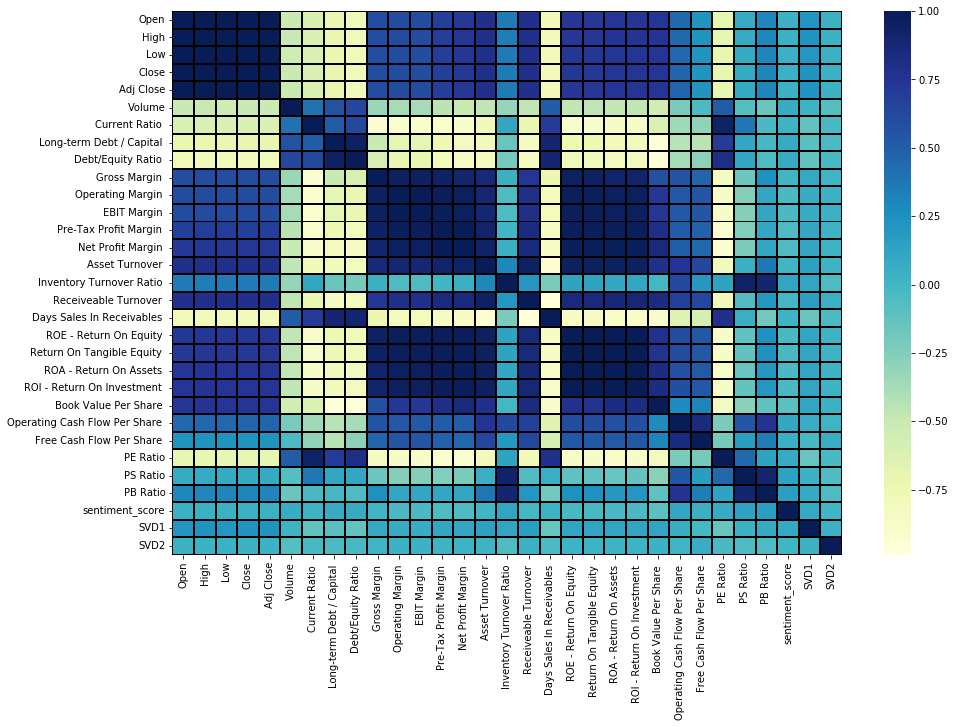

In [326]:
#Creating Correaltion plot
ax = plt.subplots(figsize=(15,10))
ax= sns.heatmap(tesla.corr(), cmap="YlGnBu",linewidths=1, linecolor='black')
plt.show()

Scaling independent variable so that we can create principal componennts 

In [327]:
#Droping unimportant metrics
x= tesla.drop(["Close","Enterprise Value","Buyback Yield / Dilution","Total Shareholder Return"], axis=1)
y= tesla["Close"]


x_scaled = scaler.fit_transform(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 536 entries, 2020-06-26 to 2022-08-12
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Open                            536 non-null    float64
 1   High                            536 non-null    float64
 2   Low                             536 non-null    float64
 3   Adj Close                       536 non-null    float64
 4   Volume                          536 non-null    int64  
 5   Current Ratio                   536 non-null    float64
 6   Long-term Debt / Capital        536 non-null    float64
 7   Debt/Equity Ratio               536 non-null    float64
 8   Gross Margin                    536 non-null    float64
 9   Operating Margin                536 non-null    float64
 10  EBIT Margin                     536 non-null    float64
 11  Pre-Tax Proﬁt Margin            536 non-null    float64
 12  Net Proﬁt Margin 

### PCA

In [328]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_scaled)
df_pca = pd.DataFrame(principalComponents, columns=["PCA1","PCA2", "PCA3"])
x["PCA1"]= df_pca["PCA1"].values
x["PCA2"]= df_pca["PCA2"].values
x["PCA3"]= df_pca["PCA3"].values

In [329]:
#Understand how much variance is being captured by each component
variance_captured= pca.explained_variance_ratio_
print(variance_captured)

[0.61322619 0.12841708 0.07462549]


In [330]:
final_data= x[[ "PCA1","PCA2", "PCA3"]]
final_data["Close"]= tesla["Close"].values
final_data.head()

,PCA1,PCA2,PCA3,Close
Date,,,,
2020-06-26,8.699865,4.371002,2.333404,191.947998
2020-06-29,8.697329,4.315470,2.343713,201.869995
2020-06-30,8.862531,4.372643,2.720729,215.962006
2020-07-01,6.245791,1.458462,2.976834,223.925995
2020-07-02,6.271354,1.447504,3.077847,241.731995


### Splitting Dataset to train and test 

Train dates : 2020-06-26 00:00:00 --- 2022-06-01 00:00:00  (n=486)
Test dates  : 2022-06-02 00:00:00 --- 2022-08-12 00:00:00  (n=50)


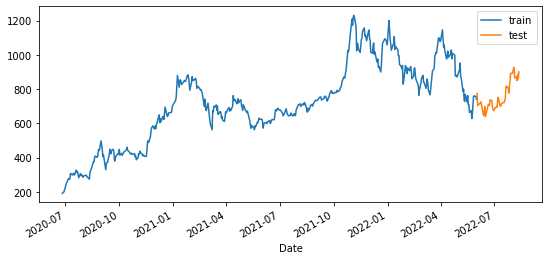

In [331]:
steps = 50
data_train = final_data[:-steps]
data_test  = final_data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
#print(y.shape)
fig, ax=plt.subplots(figsize=(9, 4))
data_train['Close'].plot(ax=ax, label='train')
data_test['Close'].plot(ax=ax, label='test')
ax.legend();

In [332]:
x_train= data_train.drop(["Close"], axis=1)
y_train= data_train["Close"]
x_test= data_test.drop(["Close"], axis=1)
y_test= data_test["Close"]
y_test.head()

Date
2022-06-02    775.000000
2022-06-03    703.549988
2022-06-06    714.840027
2022-06-07    716.659973
2022-06-08    725.599976
Name: Close, dtype: float64

### OLS
Creating a basic model and in the later part of modeling we are trying imporve accuracy(minimize error)

In [333]:
model_OS= sm.OLS(y_train,x_train).fit()
results = model_OS
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.101
Model:                            OLS   Adj. R-squared (uncentered):              0.096
Method:                 Least Squares   F-statistic:                              18.13
Date:                Sat, 13 Aug 2022   Prob (F-statistic):                    3.67e-11
Time:                        20:51:40   Log-Likelihood:                         -3881.1
No. Observations:                 486   AIC:                                      7768.
Df Residuals:                     483   BIC:                                      7781.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [334]:
test_predict1=model_OS.predict(x_test)

In [335]:
math.sqrt(mean_squared_error(y_test,test_predict1))

964.0393560776527

### Decision Tree  
After OLS we are creating decision tree model with default config

In [336]:
tree = DecisionTreeRegressor(criterion='mse',max_depth=5)
tree.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [337]:
train_predict=tree.predict(x_train)
test_predict=tree.predict(x_test)

In [338]:
math.sqrt(mean_squared_error(y_train,train_predict))

33.591465448648506

In [339]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

44.07850628163456

### Random Forest Regressor

In [340]:
rfr= RFR(criterion='mse',max_depth=5)
rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [341]:
train_rfr=rfr.predict(x_train)
test_rfr=rfr.predict(x_test)

In [342]:
math.sqrt(mean_squared_error(y_train,train_rfr))

26.00547373034182

In [343]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_rfr))

34.34282342320708

### Hypertuning

Hypertuning CatBoost Model Regressor using Gridsearch method and also cross validation=10

In [344]:
param_grid = {'iterations': [200],
              'learning_rate': [0.03, 0.1],
              'depth': [6, 8],
              'l2_leaf_reg': [0.2, 0.5]}
catb = cb.CatBoostRegressor(loss_function="RMSE")

In [345]:
Regressor1 = GridSearchCV(catb, param_grid, cv=10).fit(x_train,y_train)
print("The best hyperparameters are ",Regressor1.best_params_)

0:	learn: 193.3953648	total: 11.3ms	remaining: 2.24s
1:	learn: 188.2345867	total: 14.3ms	remaining: 1.41s
2:	learn: 183.4833748	total: 15.5ms	remaining: 1.01s
3:	learn: 178.6445429	total: 16.6ms	remaining: 815ms
4:	learn: 174.1482310	total: 17.8ms	remaining: 695ms
5:	learn: 169.4529383	total: 19.1ms	remaining: 618ms
6:	learn: 164.9953568	total: 20.2ms	remaining: 558ms
7:	learn: 160.6247886	total: 21.3ms	remaining: 512ms
8:	learn: 156.5842029	total: 22.5ms	remaining: 477ms
9:	learn: 152.6500672	total: 23.6ms	remaining: 449ms
10:	learn: 148.6011296	total: 25ms	remaining: 429ms
11:	learn: 144.9363529	total: 26ms	remaining: 408ms
12:	learn: 141.3064524	total: 27.2ms	remaining: 391ms
13:	learn: 137.6432164	total: 28.3ms	remaining: 376ms
14:	learn: 134.0982077	total: 29.5ms	remaining: 363ms
15:	learn: 130.8420749	total: 30.6ms	remaining: 352ms
16:	learn: 127.6474177	total: 31.7ms	remaining: 341ms
17:	learn: 124.4523168	total: 32.8ms	remaining: 331ms
18:	learn: 121.3974525	total: 33.8ms	remai

In [346]:
test_catb=Regressor1.predict(x_test)
math.sqrt(mean_squared_error(y_test,test_catb))

22.486297436887735

In [347]:
pd.DataFrame(list(zip(y_test,test_catb)), columns = ['Actual', 'Predicted'])

,Actual,Predicted
0,775.000000,756.918014
1,703.549988,736.272785
2,714.840027,734.330912
3,716.659973,716.719920
4,725.599976,746.451541
5,719.119995,741.040780
6,696.690002,733.290947
7,647.210022,649.279165
8,662.669983,661.278860
9,699.000000,664.864562


### Hypertuning

Hypertuning Decision tree Regressor using Gridsearch method and also cross validation=10 

In [348]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6],
           "max_features":["auto","log2","sqrt",None]}
Regressor2 = GridSearchCV(tree, parameters, cv=10).fit(x_train,y_train)

In [349]:
test_tree=Regressor2.predict(x_test)
math.sqrt(mean_squared_error(y_test,test_tree))

134.59454177862574

In [350]:
print("The best hyperparameters are ",Regressor2.best_params_)

The best hyperparameters are  {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}


### Hypertuning
Hypertuning RandomForest Regressor using Gridsearch method and also cross validation=10 

In [351]:
parameters2={'bootstrap': [True, False],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10]}
Regressor3 = GridSearchCV(rfr, parameters2, cv=10).fit(x_train,y_train)
print("The best hyperparameters are ",Regressor3.best_params_)

The best hyperparameters are  {'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [352]:
test_rand=Regressor3.predict(x_test)
math.sqrt(mean_squared_error(y_test,test_rand))

35.32184975290344

### Voting Regressor- Ensembling
We are using outputs from best from Catboost, Decision tree and random forest to create more robust model

In [353]:
VR= VotingRegressor([('CB', Regressor1), ('DT', Regressor2), ('DF', Regressor3)]).fit(x_train,y_train)

0:	learn: 193.3953648	total: 1.27ms	remaining: 253ms
1:	learn: 188.2345867	total: 2.48ms	remaining: 245ms
2:	learn: 183.4833748	total: 3.83ms	remaining: 251ms
3:	learn: 178.6445429	total: 5.14ms	remaining: 252ms
4:	learn: 174.1482310	total: 6.61ms	remaining: 258ms
5:	learn: 169.4529383	total: 7.76ms	remaining: 251ms
6:	learn: 164.9953568	total: 8.88ms	remaining: 245ms
7:	learn: 160.6247886	total: 9.92ms	remaining: 238ms
8:	learn: 156.5842029	total: 11ms	remaining: 233ms
9:	learn: 152.6500672	total: 12.1ms	remaining: 230ms
10:	learn: 148.6011296	total: 13.2ms	remaining: 227ms
11:	learn: 144.9363529	total: 14.3ms	remaining: 224ms
12:	learn: 141.3064524	total: 15.5ms	remaining: 223ms
13:	learn: 137.6432164	total: 16.7ms	remaining: 221ms
14:	learn: 134.0982077	total: 17.8ms	remaining: 220ms
15:	learn: 130.8420749	total: 18.9ms	remaining: 217ms
16:	learn: 127.6474177	total: 20ms	remaining: 216ms
17:	learn: 124.4523168	total: 21.1ms	remaining: 214ms
18:	learn: 121.3974525	total: 22.2ms	remai

In [354]:
#Prediciting using Voting Regressssor and evaluating using RMSE
final=VR.predict(x_test)
math.sqrt(mean_squared_error(y_test,final))

37.311125895660524

In [355]:
#Combining Actual and predicted on a datatfream to show how close are we from actual
price_test  = price[-steps:]

VR_predict= pd.DataFrame(list(zip(y_test,final)), columns = ['Actual', 'Predicted'], index =price_test["Date"])
VR_predict.head()

,Actual,Predicted
Date,,
2022-06-02,775.000000,735.492499
2022-06-03,703.549988,728.278290
2022-06-06,714.840027,727.630999
2022-06-07,716.659973,721.237592
2022-06-08,725.599976,731.671208


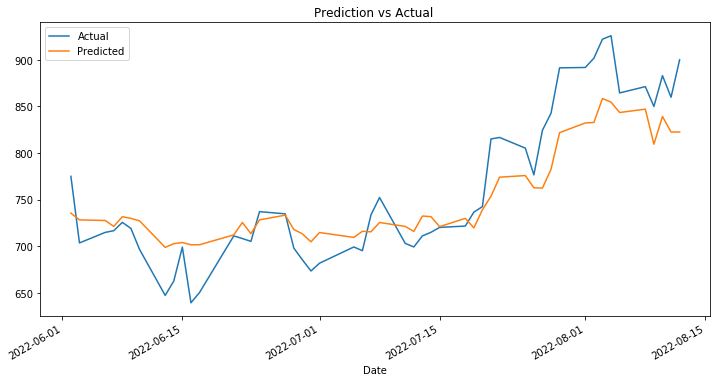

In [356]:
#Comparing Actual and predicted on the chart
VR_predict['Actual'].plot(legend=True,figsize=(12,6),title="Prediction vs Actual " )
VR_predict['Predicted'].plot(legend=True)

### Creating Pickle file

In [357]:
#Pickle file of Voting Regression
file_name='VR.pkl'
f = open(file_name,'wb')
pickle.dump(VR,f)
f.close()

In [358]:
#Pickle file of OLS- baseline model
file_name='model_OLS.pkl'
O = open(file_name,'wb')
pickle.dump(model_OS,O)
O.close()

### Forecasting
combined test and train and fitiing ARIMA model to forecast for 30 days in future

In [359]:
pred_y= VR_predict["Predicted"]
train_y= data_train["Close"]
combined = pd.concat([train_y, pred_y])
combined= pd.DataFrame(combined, columns =['Close'])
combined.head()

,Close
Date,
2020-06-26,191.947998
2020-06-29,201.869995
2020-06-30,215.962006
2020-07-01,223.925995
2020-07-02,241.731995


In [360]:
#Using Autoarima to p,q,d
auto_arima(combined['Close']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  536
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2559.341
Date:                Sat, 13 Aug 2022   AIC                           5120.682
Time:                        20:55:01   BIC                           5124.965
Sample:                             0   HQIC                          5122.358
                                - 536                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       836.9444     30.732     27.234      0.000     776.710     897.178
===================================================================================
Ljung-Box (Q):                       63.36   Jarque-Bera (JB):               287.19
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [361]:
#Building Arima Model
arima_model = ARIMA(combined['Close'],order=(0,1,0))
model = arima_model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  535
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2558.897
Method:                           css   S.D. of innovations             28.906
Date:                Sat, 13 Aug 2022   AIC                           5121.794
Time:                        20:55:01   BIC                           5130.358
Sample:                             1   HQIC                          5125.144
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1787      1.250      0.943      0.346      -1.271       3.628
==============================================================================
"""

In [362]:
#Forecasting for 30 days in the future
forecast = model.predict(len(combined),len(combined)+30,typ='levels').rename('Forecast')
forecast.head()

535    823.744406
536    824.923131
537    826.101855
538    827.280579
539    828.459304
Name: Forecast, dtype: float64

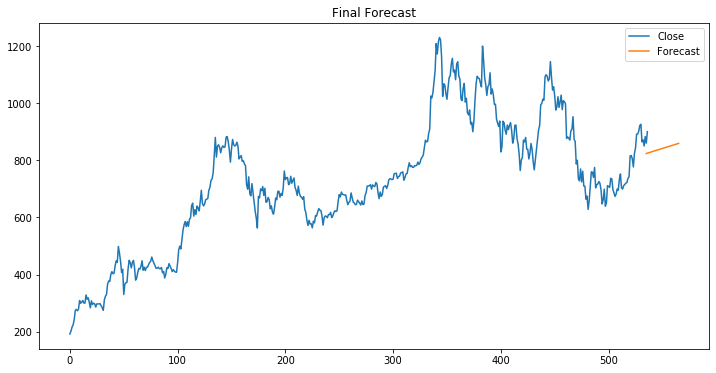

In [363]:
#Visualizing forecast
price['Close'].plot(legend=True,figsize=(12,6),title="Final Forecast")
forecast.plot(legend=True)